<a href="https://colab.research.google.com/github/soulsharp/AutoCoco/blob/main/AutoCoco2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
!pip install efficientnet_pytorch
!pip install timm

In [52]:
import torch
from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, random_split
from PIL import Image
from torch import nn, optim
import os
import shutil
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import timm
import time

In [17]:
# # Data Augmentation
# augmentation_transform = A.Compose([
#     A.Resize(256, 256),
#     A.HorizontalFlip(p=0.5),
#     A.VerticalFlip(p=0.5),
#     A.RandomRotate90(p=0.5),
#     A.Normalize(),
#     ToTensorV2(),
# ])

In [18]:
# Manually specify class folders
class_folders = ["Bud Root Drooping", "Bud Rot", "Gray Leaf Spot", "Leaf Rot", "Stem Bleeding"]
class_folders = [folder for folder in class_folders if folder not in [".ipynb_checkpoints", ".config", "sample_data"]]


In [19]:
!rm -R /content/.ipynb_checkpoints
!ls /content/ -a   #to make sure that the deletion has occurred

rm: cannot remove '/content/.ipynb_checkpoints': No such file or directory
 .   ..  'Bud Root Drooping'  'Bud Rot'  'Gray Leaf Spot'  'Leaf Rot'  'Stem Bleeding'


In [20]:
!rm -R /content/.config

rm: cannot remove '/content/.config': No such file or directory


In [21]:
!ls /content/ -a

 .   ..  'Bud Root Drooping'  'Bud Rot'  'Gray Leaf Spot'  'Leaf Rot'  'Stem Bleeding'


In [22]:
!rm -R /content/sample_data

rm: cannot remove '/content/sample_data': No such file or directory


In [23]:
!ls /content/ -a

 .   ..  'Bud Root Drooping'  'Bud Rot'  'Gray Leaf Spot'  'Leaf Rot'  'Stem Bleeding'


In [24]:
root_dir = "/content"
filtered_root = "/dataset"
exclude_dirs = [".ipynb_checkpoints", ".config"]
if not os.path.exists(filtered_root):
    os.makedirs(filtered_root)

# Moves only the relevant class folders
for class_folder in os.listdir(root_dir):
    if class_folder not in exclude_dirs and os.path.isdir(os.path.join(root_dir, class_folder)):
        destination_path = os.path.join(filtered_root, class_folder)

        # Checks if the destination directory already exists
        if not os.path.exists(destination_path):
            shutil.copytree(os.path.join(root_dir, class_folder), destination_path)


In [25]:
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [26]:
dataset = datasets.ImageFolder(root=root_dir, transform=image_transform)

In [27]:
dataset.class_to_idx.items()

dict_items([('Bud Root Drooping', 0), ('Bud Rot', 1), ('Gray Leaf Spot', 2), ('Leaf Rot', 3), ('Stem Bleeding', 4)])

In [28]:
len(dataset), len(dataset.targets)

(757, 757)

In [29]:
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [30]:
# def visualize_augmented_images(original_images, augmented_images):
#     num_images = len(original_images)
#     fig, axes = plt.subplots(num_images, 2, figsize=(8, num_images * 4))

#     for i in range(num_images):
#         axes[i, 0].imshow(np.transpose(original_images[i], (1, 2, 0)))
#         axes[i, 0].set_title('Original Image')
#         axes[i, 0].axis('off')

#         axes[i, 1].imshow(np.transpose(augmented_images[i], (1, 2, 0)))
#         axes[i, 1].set_title('Augmented Image')
#         axes[i, 1].axis('off')

#     plt.show()


In [31]:
class CustomModel(nn.Module):
    def __init__(self, num_classes):
        super(CustomModel, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Flattens the tensor for the linear layer
        _, channels, height, width = self._get_dummy_output_shape()
        self.fc_input_size = channels * height * width

        self.classifier = nn.Sequential(
            nn.Linear(self.fc_input_size, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes),
        )


    def forward(self, x):
        for layer in self.features:
            x = layer(x)

        x = x.view(x.size(0), -1)
        logits = self.classifier(x)
        return logits

         # During training, calculates probabilities using softmax
        if self.training:
            probabilities = nn.functional.softmax(logits, dim=1)
            return probabilities
        else:
            # During inference, returns the class index with the highest probability
            _, predicted_labels = torch.max(logits, 1)
            return predicted_labels


    def _get_dummy_output_shape(self):
        # Helper function to get the output shape
        test_tensor = torch.randn(1, 3, 256, 256)
        for layer in self.features:
            test_tensor = layer(test_tensor)
        return test_tensor.size()

In [32]:
def plot_metrics(epochs, train_values, val_values, y_label, title):
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, train_values, label=f'Training {y_label}')
    plt.plot(epochs, val_values, label=f'Validation {y_label}')
    plt.xlabel('Epochs')
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.show()

In [33]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [34]:
def plot_precision_recall_curve(y_true, y_pred, num_classes):
    precision = [precision_score(y_true, y_pred, average='micro')]
    recall = [recall_score(y_true, y_pred, average='micro')]

    for class_idx in range(num_classes):
        precision.append(precision_score(y_true == class_idx, y_pred == class_idx))
        recall.append(recall_score(y_true == class_idx, y_pred == class_idx))

    plt.figure(figsize=(12, 6))
    plt.bar(range(num_classes + 1), precision, color='blue', alpha=0.7, label='Precision')
    plt.bar(range(num_classes + 1), recall, color='green', alpha=0.7, label='Recall')
    plt.xticks(range(num_classes + 1), ['Overall'] + class_folders, rotation=45)

In [35]:
# # Training Loop
# def train(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=5):
#     train_loss_list = []
#     val_loss_list = []
#     train_accuracy_list = []
#     val_accuracy_list = []
#     f1_list = []

#     for epoch in range(num_epochs):
#         model.train()
#         running_loss = 0.0
#         predictions = []
#         true_labels = []

#         for batch_idx, (data, labels) in enumerate(train_dataloader):
#             optimizer.zero_grad()
#             outputs = model(data)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
#             running_loss += loss.item()

#             # Tracks true labels and predictions for metrics calculation
#             predictions.extend(torch.argmax(outputs, dim=1).cpu().numpy())
#             true_labels.extend(labels.cpu().numpy())

#             if batch_idx % 10 == 0:
#                 print(f'Train Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}/{len(train_dataloader)}, Loss: {loss.item():.4f}')

#         # Calculates training accuracy
#         train_accuracy = accuracy_score(true_labels, predictions)
#         train_accuracy_list.append(train_accuracy)
#         train_loss = running_loss / len(train_dataloader)
#         train_loss_list.append(train_loss)

#         # calculates precision, recall, and confusion matrix for validation set
#     model.eval()
#     all_predictions_val = []
#     all_true_labels_val = []

#     with torch.no_grad():
#         for data_val, labels_val in val_dataloader:
#             outputs_val = model(data_val)
#             predictions_val = torch.argmax(outputs_val, dim=1).cpu().numpy()
#             true_labels_val = labels_val.cpu().numpy()

#             all_predictions_val.extend(predictions_val)
#             all_true_labels_val.extend(true_labels_val)

#     # Calculate metrics
#     val_accuracy = accuracy_score(all_true_labels_val, all_predictions_val)
#     val_precision = precision_score(all_true_labels_val, all_predictions_val, average=None)
#     val_recall = recall_score(all_true_labels_val, all_predictions_val, average=None)
#     val_f1 = f1_score(all_true_labels_val, all_predictions_val, average=None)

#     # Confusion Matrix
#     cm = confusion_matrix(all_true_labels_val, all_predictions_val)

#     # Class-wise Heatmap
#     plt.figure(figsize=(10, 8))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_folders, yticklabels=class_folders)
#     plt.xlabel('Predicted Labels')
#     plt.ylabel('True Labels')
#     plt.title('Confusion Matrix')
#     plt.show()

#     #Bar Graph for Precision and Recall
#     x = np.arange(len(class_folders))
#     width = 0.35

#     plt.figure(figsize=(12, 6))
#     plt.bar(x - width/2, val_precision, width, label='Precision')
#     plt.bar(x + width/2, val_recall, width, label='Recall')
#     plt.xlabel('Classes')
#     plt.ylabel('Score')
#     plt.title('Precision and Recall by Class')
#     plt.xticks(x, class_folders)
#     plt.legend()
#     plt.show()

#     print(f'Validation Accuracy: {val_accuracy:.4f}')
#     print('Class-wise Metrics:')
#     for i, class_name in enumerate(class_folders):
#         print(f'Class: {class_name}, Precision: {val_precision[i]:.4f}, Recall: {val_recall[i]:.4f}, F1 Score: {val_f1[i]:.4f}')


In [36]:
# Training Loop to get accuracy plots
def train_accuracy_metrics(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=5):
    train_loss_list = []
    val_loss_list = []
    train_accuracy_list = []
    val_accuracy_list = []
    f1_list = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        predictions = []
        true_labels = []

        for batch_idx, (data, labels) in enumerate(train_dataloader):
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # Track true labels and predictions for metrics calculation
            predictions.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

            if batch_idx % 10 == 0:
                print(f'Train Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}/{len(train_dataloader)}, Loss: {loss.item():.4f}')

        # Calculates training accuracy
        train_accuracy = accuracy_score(true_labels, predictions)
        train_accuracy_list.append(train_accuracy)
        train_loss = running_loss / len(train_dataloader)
        train_loss_list.append(train_loss)

        # Validation
        model.eval()
        running_loss_val = 0.0
        predictions_val = []
        true_labels_val = []

        with torch.no_grad():
            for data_val, labels_val in val_dataloader:
                outputs_val = model(data_val)
                loss_val = criterion(outputs_val, labels_val)
                running_loss_val += loss_val.item()

                # Tracks true labels and predictions for metrics calculation
                predictions_val.extend(torch.argmax(outputs_val, dim=1).cpu().numpy())
                true_labels_val.extend(labels_val.cpu().numpy())

        # Calculates validation accuracy
        val_accuracy = accuracy_score(true_labels_val, predictions_val)
        val_accuracy_list.append(val_accuracy)
        val_loss = running_loss_val / len(val_dataloader)
        val_loss_list.append(val_loss)

        # Calculates F1 score
        f1 = f1_score(true_labels_val, predictions_val, average='weighted')
        f1_list.append(f1)

        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, '
              f'Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}, F1 Score: {f1:.4f}')

    # Plots
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), train_loss_list, label='Training Loss')
    plt.plot(range(1, num_epochs+1), val_loss_list, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs+1), train_accuracy_list, label='Training Accuracy')
    plt.plot(range(1, num_epochs+1), val_accuracy_list, label='Validation Accuracy')
    plt.plot(range(1, num_epochs+1), f1_list, label='F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()

    plt.show()

In [37]:
def train(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=5):
    train_loss_list = []
    val_loss_list = []
    train_accuracy_list = []
    val_accuracy_list = []
    f1_list = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        predictions = []
        true_labels = []

        for batch_idx, (data, labels) in enumerate(train_dataloader):
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # Tracks true labels and predictions for metrics calculation
            predictions.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

            if batch_idx % 10 == 0:
                print(f'Train Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}/{len(train_dataloader)}, Loss: {loss.item():.4f}')

        # Append training loss for plotting
        train_loss_list.append(running_loss / len(train_dataloader))

        # Calculates training accuracy
        train_accuracy = accuracy_score(true_labels, predictions)
        train_accuracy_list.append(train_accuracy)

        # Validation Metrics Calculation
        model.eval()
        all_predictions_val = []
        all_true_labels_val = []

        with torch.no_grad():
            for data_val, labels_val in val_dataloader:
                outputs_val = model(data_val)
                predictions_val = torch.argmax(outputs_val, dim=1).cpu().numpy()
                true_labels_val = labels_val.cpu().numpy()

                all_predictions_val.extend(predictions_val)
                all_true_labels_val.extend(true_labels_val)

        # Calculate metrics
        val_accuracy = accuracy_score(all_true_labels_val, all_predictions_val)
        val_precision = precision_score(all_true_labels_val, all_predictions_val, average=None)
        val_recall = recall_score(all_true_labels_val, all_predictions_val, average=None)
        val_f1 = f1_score(all_true_labels_val, all_predictions_val, average=None)

        # Confusion Matrix
        cm = confusion_matrix(all_true_labels_val, all_predictions_val)

        # Class-wise Heatmap
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_folders, yticklabels=class_folders)
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.show()

        # Bar Graph for Precision and Recall
        x = np.arange(len(class_folders))
        width = 0.35

        plt.figure(figsize=(12, 6))
        plt.bar(x - width/2, val_precision, width, label='Precision')
        plt.bar(x + width/2, val_recall, width, label='Recall')
        plt.xlabel('Classes')
        plt.ylabel('Score')
        plt.title('Precision and Recall by Class')
        plt.xticks(x, class_folders)
        plt.legend()
        plt.show()

        # Print metrics
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss_list[-1]:.4f}, Validation Accuracy: {val_accuracy:.4f}')
        print('Class-wise Metrics:')
        for i, class_name in enumerate(class_folders):
            print(f'Class: {class_name}, Precision: {val_precision[i]:.4f}, Recall: {val_recall[i]:.4f}, F1 Score: {val_f1[i]:.4f}')

        # Append validation metrics for plotting
        val_loss_list.append(train_loss_list[-1])  # Use the last training loss for validation

        val_accuracy_list.append(val_accuracy)
        f1_list.append(np.mean(val_f1))

    # Plots
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), train_loss_list, label='Training Loss')
    plt.plot(range(1, num_epochs+1), val_loss_list, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs+1), train_accuracy_list, label='Training Accuracy')
    plt.plot(range(1, num_epochs+1), val_accuracy_list, label='Validation Accuracy')
    plt.plot(range(1, num_epochs+1), f1_list, label='F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()

    plt.show()



In [38]:
batch_size = 16
lr = 1e-3
num_epochs = 5

Train Epoch 1/5, Batch 1/38, Loss: 1.6262
Train Epoch 1/5, Batch 11/38, Loss: 1.5500
Train Epoch 1/5, Batch 21/38, Loss: 1.6720
Train Epoch 1/5, Batch 31/38, Loss: 1.2183


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


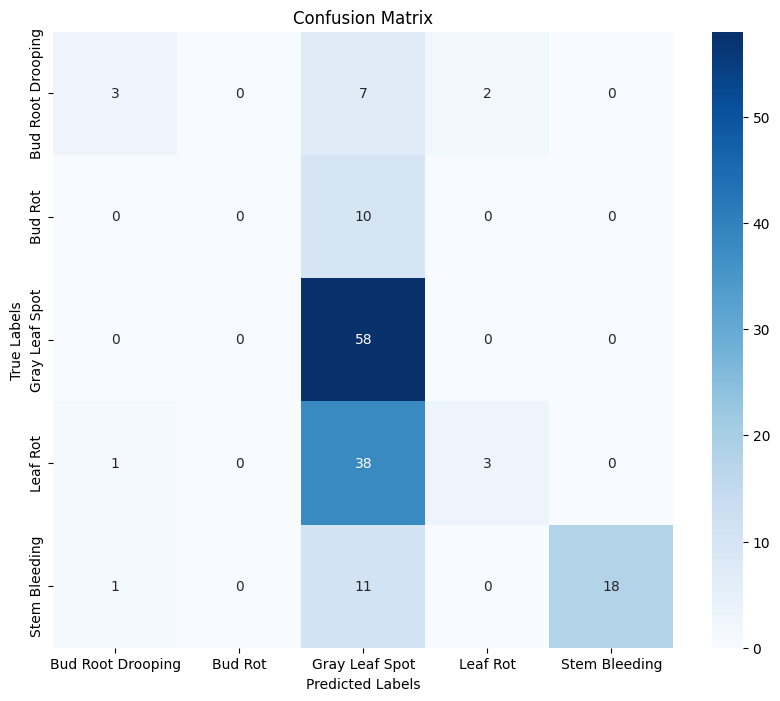

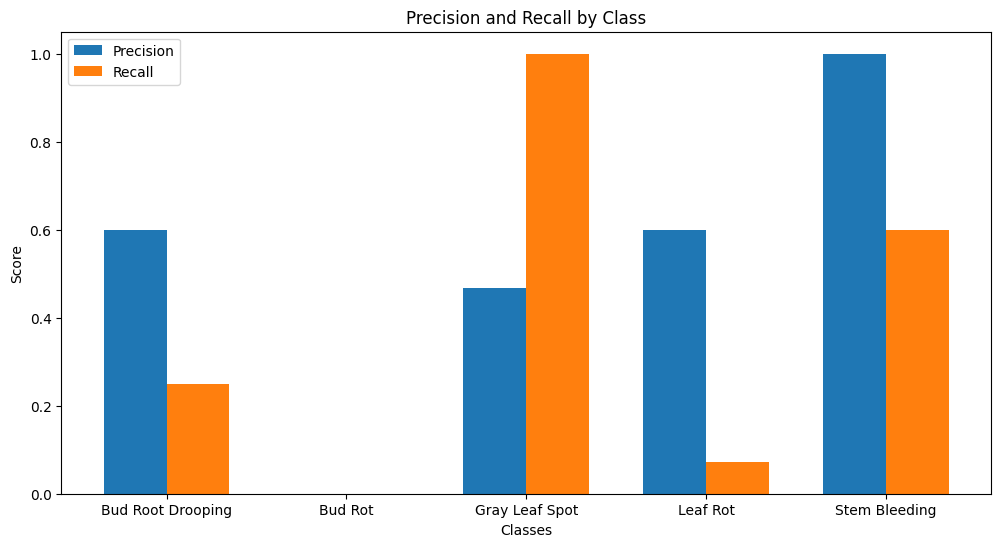

Epoch 1/5, Training Loss: 1.3990, Validation Accuracy: 0.5395
Class-wise Metrics:
Class: Bud Root Drooping, Precision: 0.6000, Recall: 0.2500, F1 Score: 0.3529
Class: Bud Rot, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Gray Leaf Spot, Precision: 0.4677, Recall: 1.0000, F1 Score: 0.6374
Class: Leaf Rot, Precision: 0.6000, Recall: 0.0714, F1 Score: 0.1277
Class: Stem Bleeding, Precision: 1.0000, Recall: 0.6000, F1 Score: 0.7500
Train Epoch 2/5, Batch 1/38, Loss: 1.0564
Train Epoch 2/5, Batch 11/38, Loss: 1.1709
Train Epoch 2/5, Batch 21/38, Loss: 1.0485
Train Epoch 2/5, Batch 31/38, Loss: 0.6854


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


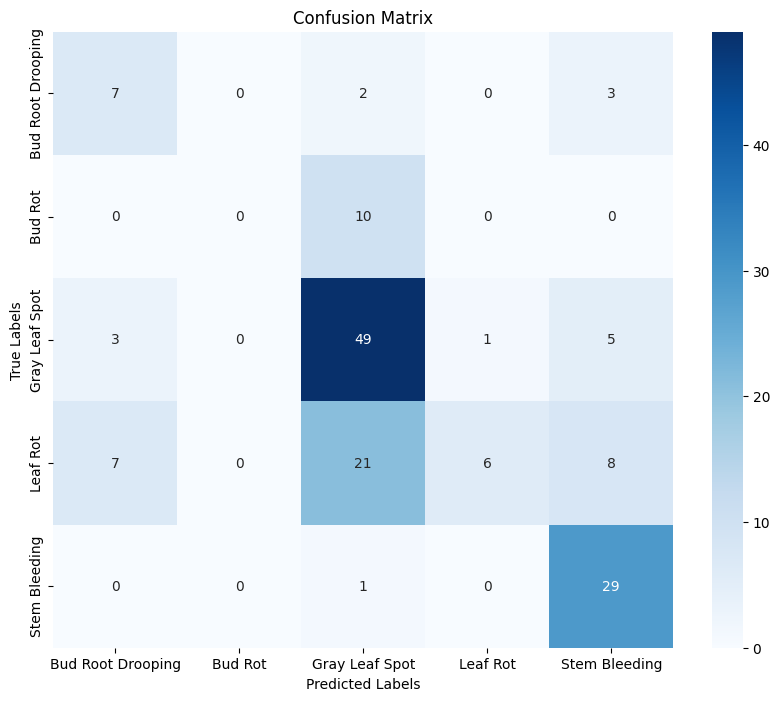

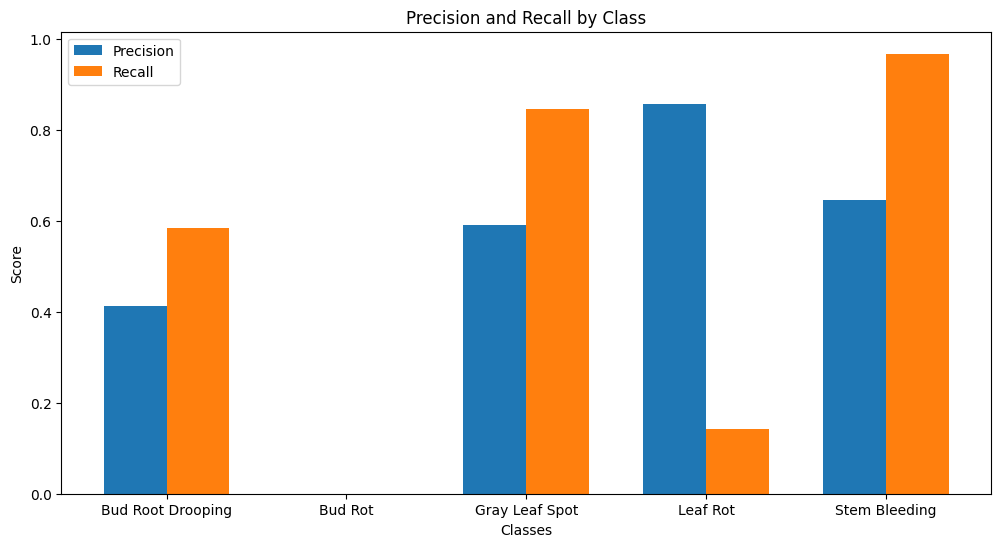

Epoch 2/5, Training Loss: 0.9380, Validation Accuracy: 0.5987
Class-wise Metrics:
Class: Bud Root Drooping, Precision: 0.4118, Recall: 0.5833, F1 Score: 0.4828
Class: Bud Rot, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Gray Leaf Spot, Precision: 0.5904, Recall: 0.8448, F1 Score: 0.6950
Class: Leaf Rot, Precision: 0.8571, Recall: 0.1429, F1 Score: 0.2449
Class: Stem Bleeding, Precision: 0.6444, Recall: 0.9667, F1 Score: 0.7733
Train Epoch 3/5, Batch 1/38, Loss: 1.1414
Train Epoch 3/5, Batch 11/38, Loss: 0.6357
Train Epoch 3/5, Batch 21/38, Loss: 0.4864
Train Epoch 3/5, Batch 31/38, Loss: 0.7894


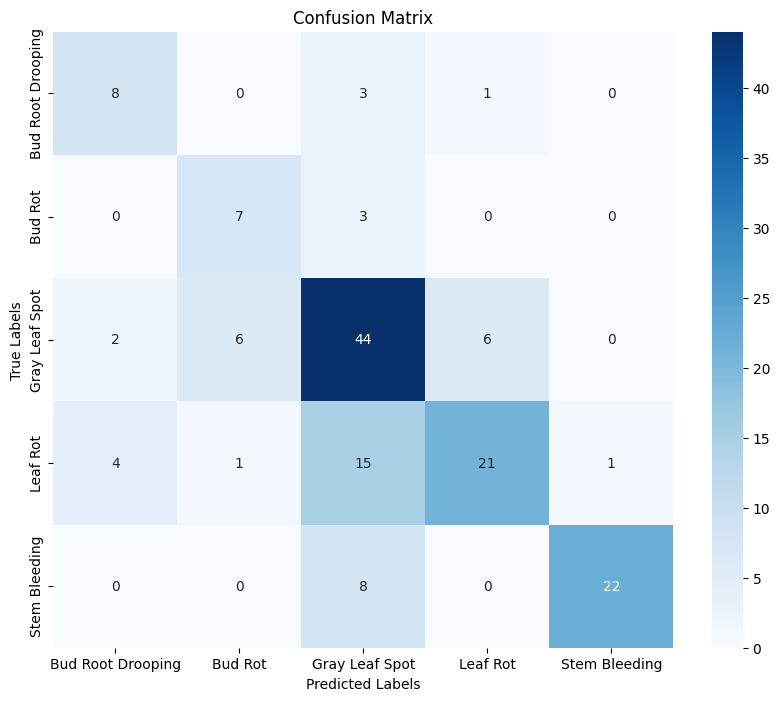

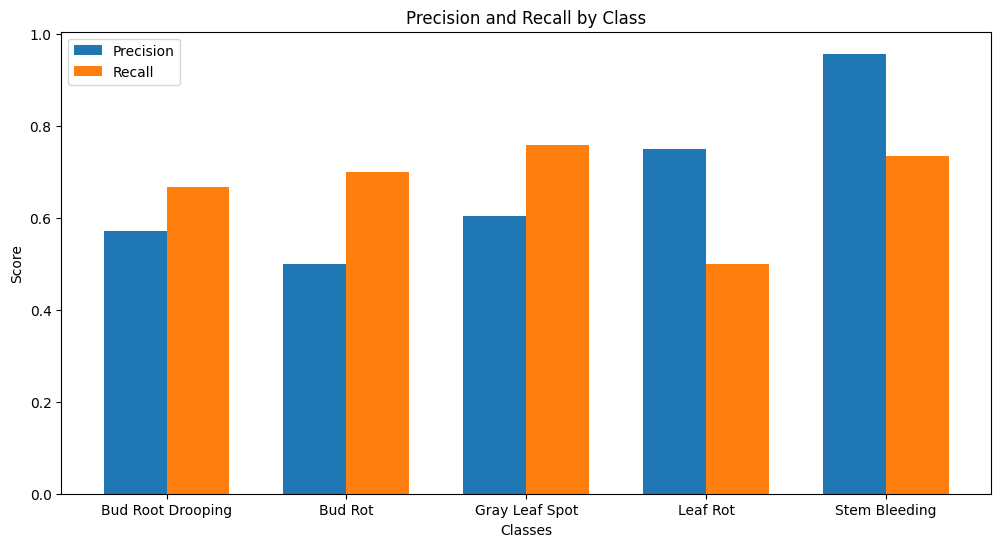

Epoch 3/5, Training Loss: 0.7351, Validation Accuracy: 0.6711
Class-wise Metrics:
Class: Bud Root Drooping, Precision: 0.5714, Recall: 0.6667, F1 Score: 0.6154
Class: Bud Rot, Precision: 0.5000, Recall: 0.7000, F1 Score: 0.5833
Class: Gray Leaf Spot, Precision: 0.6027, Recall: 0.7586, F1 Score: 0.6718
Class: Leaf Rot, Precision: 0.7500, Recall: 0.5000, F1 Score: 0.6000
Class: Stem Bleeding, Precision: 0.9565, Recall: 0.7333, F1 Score: 0.8302
Train Epoch 4/5, Batch 1/38, Loss: 0.6224
Train Epoch 4/5, Batch 11/38, Loss: 0.8140
Train Epoch 4/5, Batch 21/38, Loss: 0.6406
Train Epoch 4/5, Batch 31/38, Loss: 0.2327


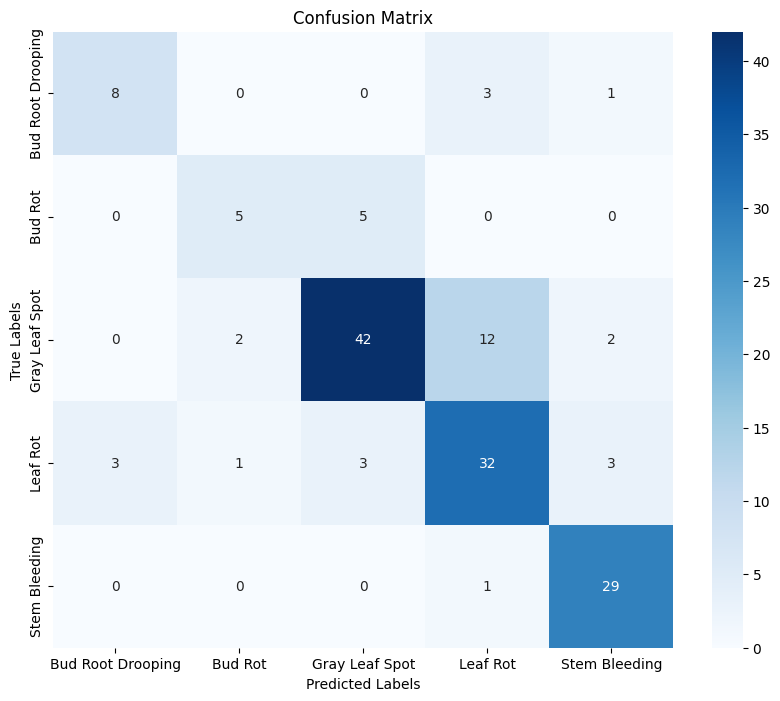

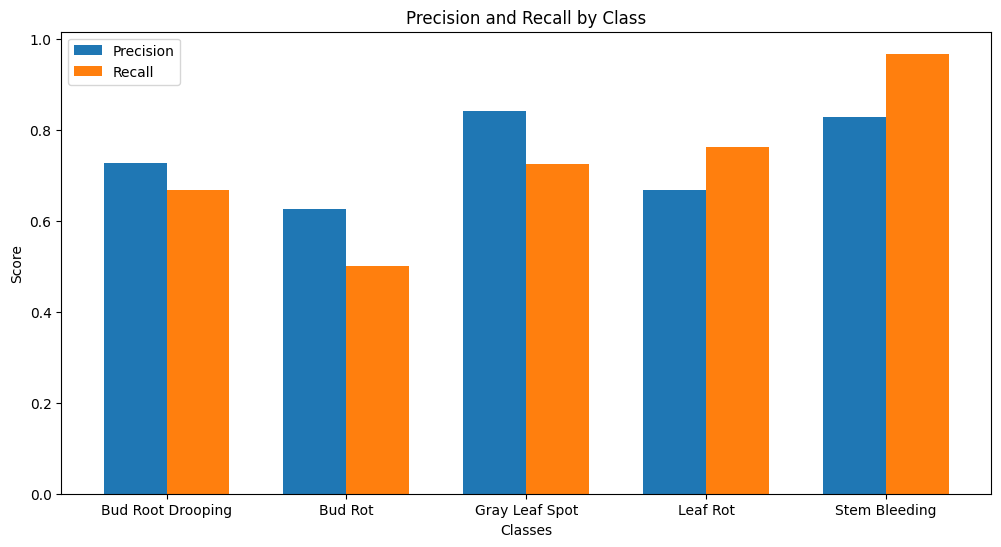

Epoch 4/5, Training Loss: 0.6708, Validation Accuracy: 0.7632
Class-wise Metrics:
Class: Bud Root Drooping, Precision: 0.7273, Recall: 0.6667, F1 Score: 0.6957
Class: Bud Rot, Precision: 0.6250, Recall: 0.5000, F1 Score: 0.5556
Class: Gray Leaf Spot, Precision: 0.8400, Recall: 0.7241, F1 Score: 0.7778
Class: Leaf Rot, Precision: 0.6667, Recall: 0.7619, F1 Score: 0.7111
Class: Stem Bleeding, Precision: 0.8286, Recall: 0.9667, F1 Score: 0.8923
Train Epoch 5/5, Batch 1/38, Loss: 0.2489
Train Epoch 5/5, Batch 11/38, Loss: 0.4938
Train Epoch 5/5, Batch 21/38, Loss: 0.3147
Train Epoch 5/5, Batch 31/38, Loss: 0.2429


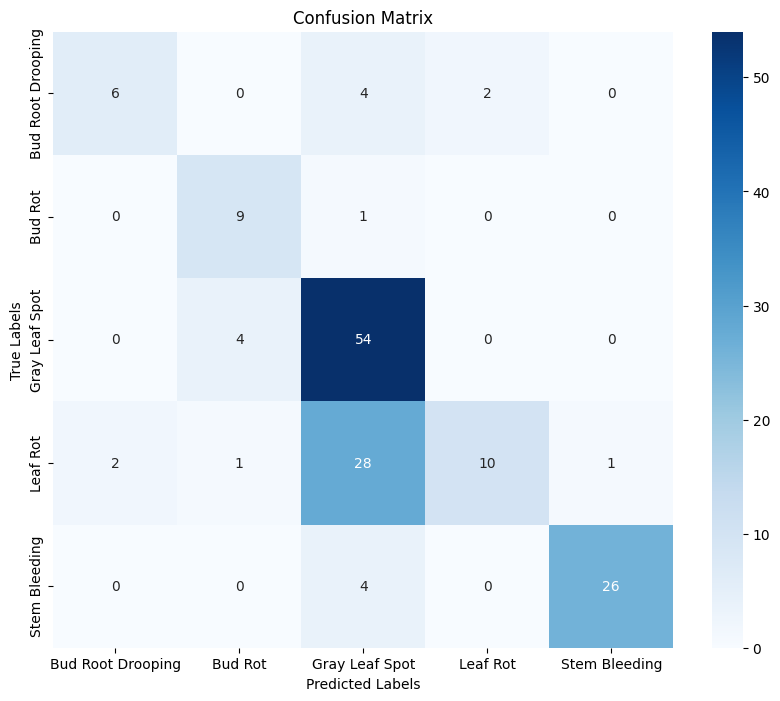

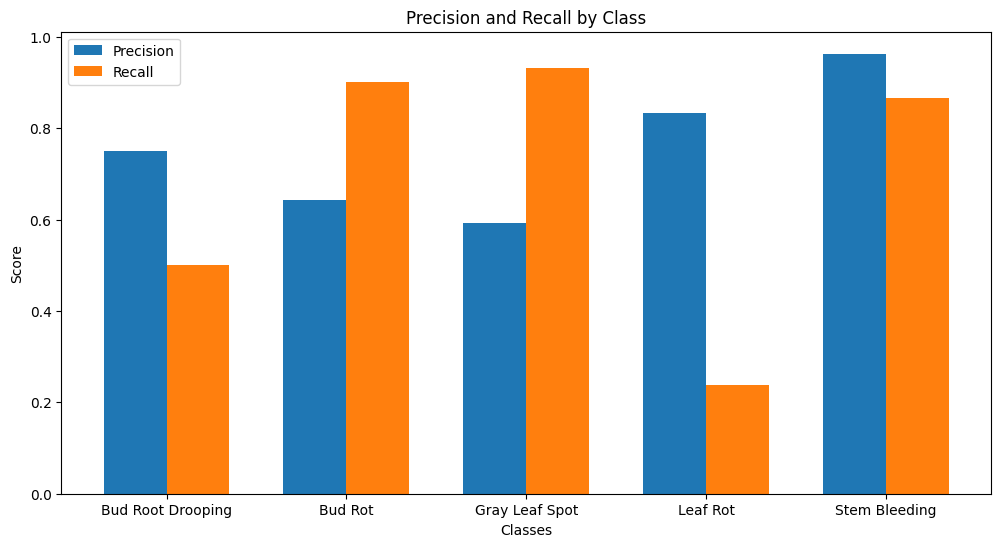

Epoch 5/5, Training Loss: 0.4126, Validation Accuracy: 0.6908
Class-wise Metrics:
Class: Bud Root Drooping, Precision: 0.7500, Recall: 0.5000, F1 Score: 0.6000
Class: Bud Rot, Precision: 0.6429, Recall: 0.9000, F1 Score: 0.7500
Class: Gray Leaf Spot, Precision: 0.5934, Recall: 0.9310, F1 Score: 0.7248
Class: Leaf Rot, Precision: 0.8333, Recall: 0.2381, F1 Score: 0.3704
Class: Stem Bleeding, Precision: 0.9630, Recall: 0.8667, F1 Score: 0.9123


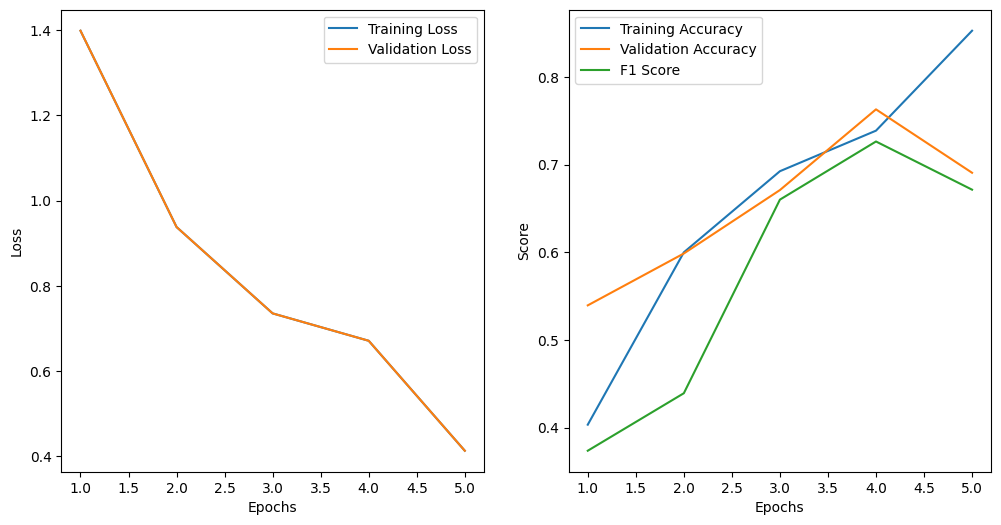

In [39]:
model = CustomModel(num_classes=5)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size=batch_size, shuffle=False)
train(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=num_epochs)


Train Epoch 1/5, Batch 1/38, Loss: 1.0081
Train Epoch 1/5, Batch 11/38, Loss: 0.7213
Train Epoch 1/5, Batch 21/38, Loss: 0.5009
Train Epoch 1/5, Batch 31/38, Loss: 0.2394
Epoch 1/5, Training Loss: 0.4416, Validation Loss: 0.6631, Training Accuracy: 0.8364, Validation Accuracy: 0.7961, F1 Score: 0.7946
Train Epoch 2/5, Batch 1/38, Loss: 0.1035
Train Epoch 2/5, Batch 11/38, Loss: 0.0222
Train Epoch 2/5, Batch 21/38, Loss: 0.1833
Train Epoch 2/5, Batch 31/38, Loss: 0.0360
Epoch 2/5, Training Loss: 0.1491, Validation Loss: 0.4728, Training Accuracy: 0.9636, Validation Accuracy: 0.8618, F1 Score: 0.8612
Train Epoch 3/5, Batch 1/38, Loss: 0.2630
Train Epoch 3/5, Batch 11/38, Loss: 0.3990
Train Epoch 3/5, Batch 21/38, Loss: 0.4006
Train Epoch 3/5, Batch 31/38, Loss: 0.2305
Epoch 3/5, Training Loss: 0.2380, Validation Loss: 0.3736, Training Accuracy: 0.9124, Validation Accuracy: 0.8750, F1 Score: 0.8759
Train Epoch 4/5, Batch 1/38, Loss: 0.0945
Train Epoch 4/5, Batch 11/38, Loss: 0.0354
Train 

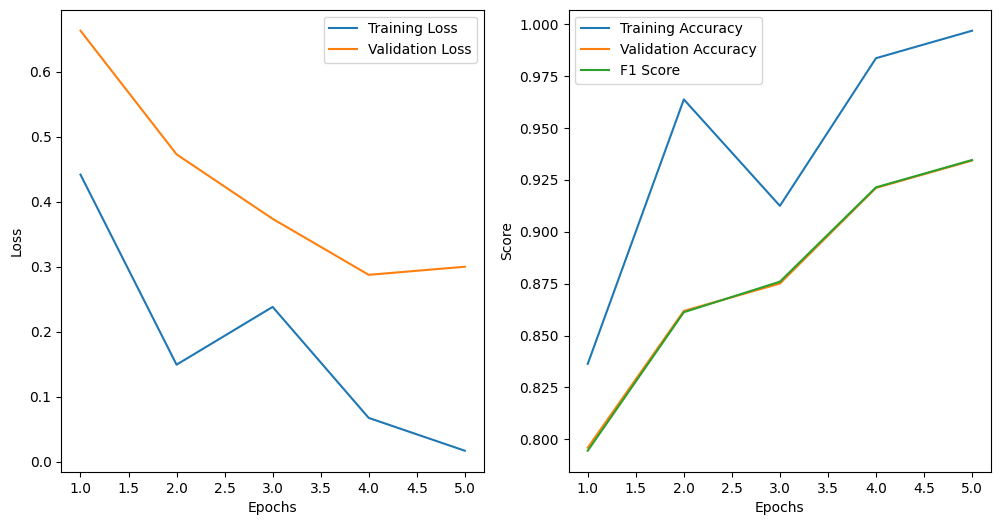

In [40]:
train_accuracy_metrics(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=5)

In [41]:
mobilenet_v2 = models.mobilenet_v2(pretrained=True)

# Modifies the last layer
num_classes = len(class_folders)
mobilenet_v2.classifier[-1] = nn.Linear(mobilenet_v2.classifier[-1].in_features, num_classes)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Defines criterion, optimizer, and other parameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet_v2.parameters(), lr=0.001)



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 95.2MB/s]


Train Epoch 1/5, Batch 1/38, Loss: 1.7538
Train Epoch 1/5, Batch 11/38, Loss: 0.0499
Train Epoch 1/5, Batch 21/38, Loss: 0.1521
Train Epoch 1/5, Batch 31/38, Loss: 0.1537


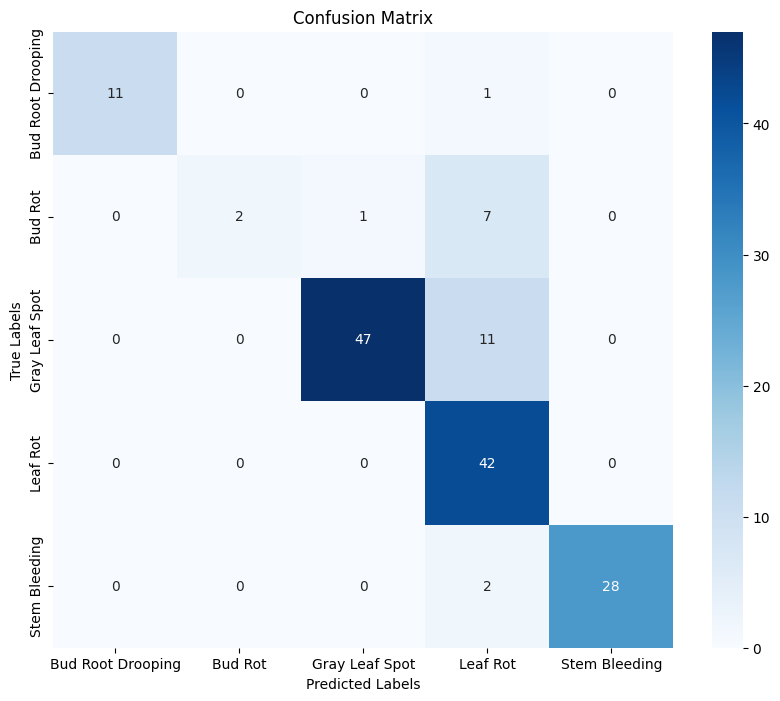

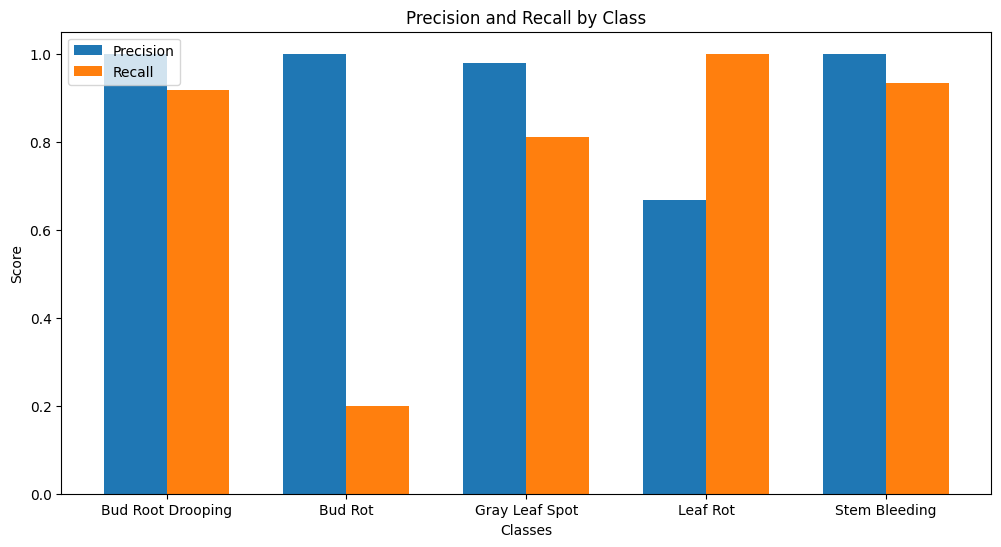

Epoch 1/5, Training Loss: 0.4087, Validation Accuracy: 0.8553
Class-wise Metrics:
Class: Bud Root Drooping, Precision: 1.0000, Recall: 0.9167, F1 Score: 0.9565
Class: Bud Rot, Precision: 1.0000, Recall: 0.2000, F1 Score: 0.3333
Class: Gray Leaf Spot, Precision: 0.9792, Recall: 0.8103, F1 Score: 0.8868
Class: Leaf Rot, Precision: 0.6667, Recall: 1.0000, F1 Score: 0.8000
Class: Stem Bleeding, Precision: 1.0000, Recall: 0.9333, F1 Score: 0.9655
Train Epoch 2/5, Batch 1/38, Loss: 0.0513
Train Epoch 2/5, Batch 11/38, Loss: 0.6793
Train Epoch 2/5, Batch 21/38, Loss: 0.0779
Train Epoch 2/5, Batch 31/38, Loss: 0.0181


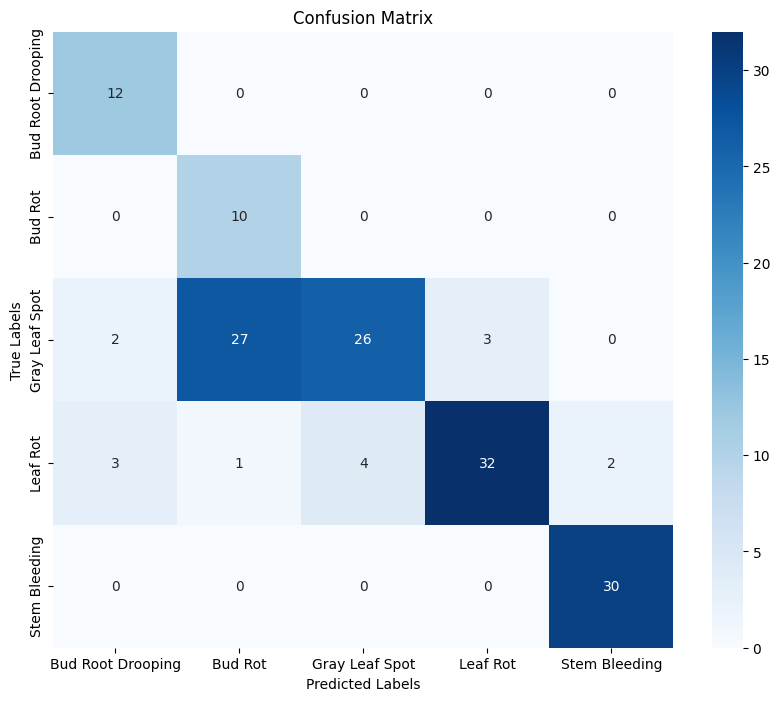

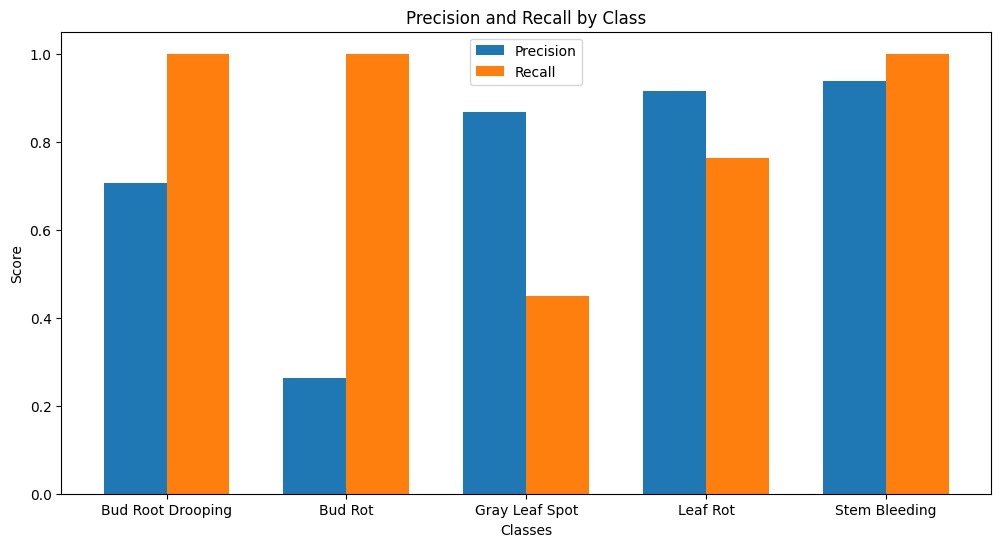

Epoch 2/5, Training Loss: 0.2974, Validation Accuracy: 0.7237
Class-wise Metrics:
Class: Bud Root Drooping, Precision: 0.7059, Recall: 1.0000, F1 Score: 0.8276
Class: Bud Rot, Precision: 0.2632, Recall: 1.0000, F1 Score: 0.4167
Class: Gray Leaf Spot, Precision: 0.8667, Recall: 0.4483, F1 Score: 0.5909
Class: Leaf Rot, Precision: 0.9143, Recall: 0.7619, F1 Score: 0.8312
Class: Stem Bleeding, Precision: 0.9375, Recall: 1.0000, F1 Score: 0.9677
Train Epoch 3/5, Batch 1/38, Loss: 0.5872
Train Epoch 3/5, Batch 11/38, Loss: 0.1006
Train Epoch 3/5, Batch 21/38, Loss: 0.0210
Train Epoch 3/5, Batch 31/38, Loss: 0.0493


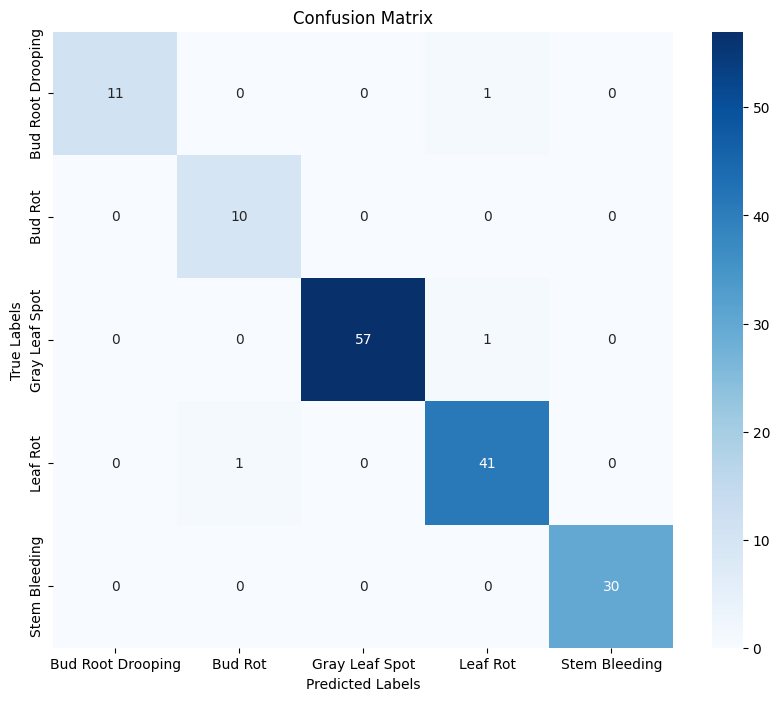

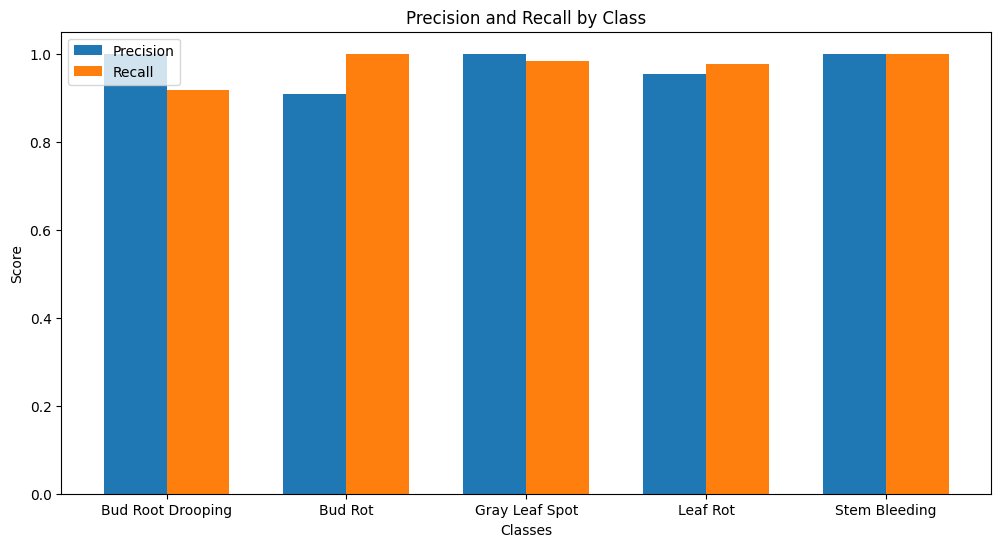

Epoch 3/5, Training Loss: 0.2637, Validation Accuracy: 0.9803
Class-wise Metrics:
Class: Bud Root Drooping, Precision: 1.0000, Recall: 0.9167, F1 Score: 0.9565
Class: Bud Rot, Precision: 0.9091, Recall: 1.0000, F1 Score: 0.9524
Class: Gray Leaf Spot, Precision: 1.0000, Recall: 0.9828, F1 Score: 0.9913
Class: Leaf Rot, Precision: 0.9535, Recall: 0.9762, F1 Score: 0.9647
Class: Stem Bleeding, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Train Epoch 4/5, Batch 1/38, Loss: 0.0883
Train Epoch 4/5, Batch 11/38, Loss: 0.0036
Train Epoch 4/5, Batch 21/38, Loss: 0.0055
Train Epoch 4/5, Batch 31/38, Loss: 0.0856


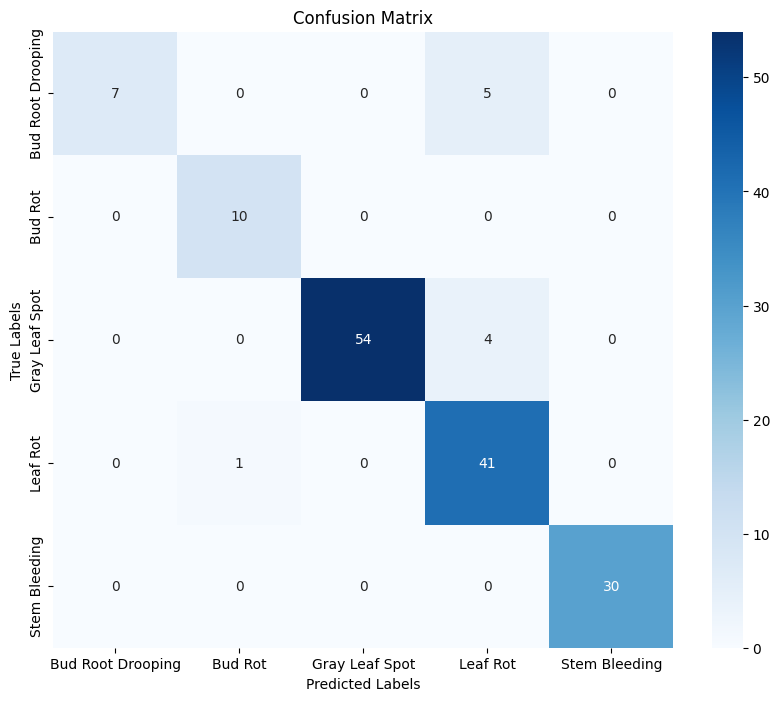

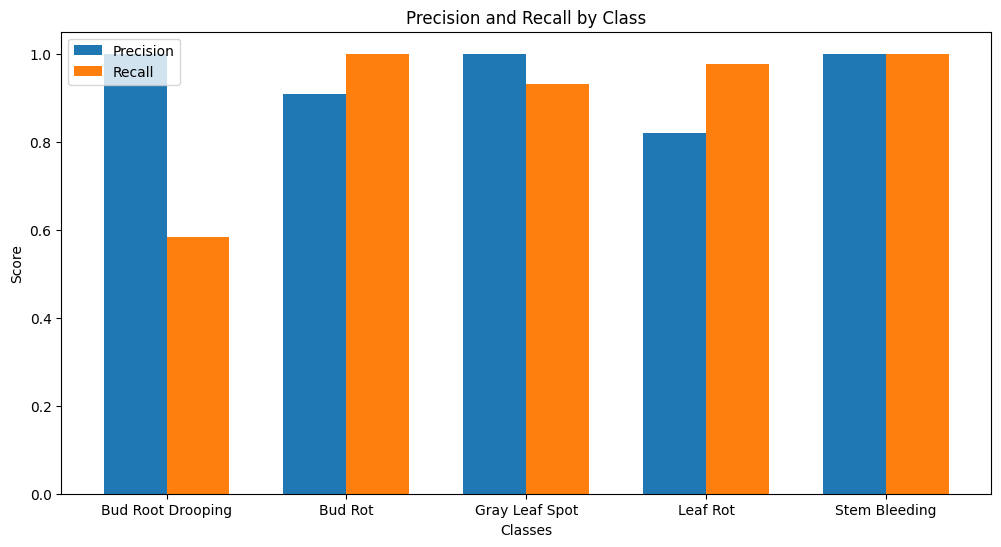

Epoch 4/5, Training Loss: 0.1027, Validation Accuracy: 0.9342
Class-wise Metrics:
Class: Bud Root Drooping, Precision: 1.0000, Recall: 0.5833, F1 Score: 0.7368
Class: Bud Rot, Precision: 0.9091, Recall: 1.0000, F1 Score: 0.9524
Class: Gray Leaf Spot, Precision: 1.0000, Recall: 0.9310, F1 Score: 0.9643
Class: Leaf Rot, Precision: 0.8200, Recall: 0.9762, F1 Score: 0.8913
Class: Stem Bleeding, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Train Epoch 5/5, Batch 1/38, Loss: 0.0453
Train Epoch 5/5, Batch 11/38, Loss: 0.0034
Train Epoch 5/5, Batch 21/38, Loss: 0.1048
Train Epoch 5/5, Batch 31/38, Loss: 0.0249


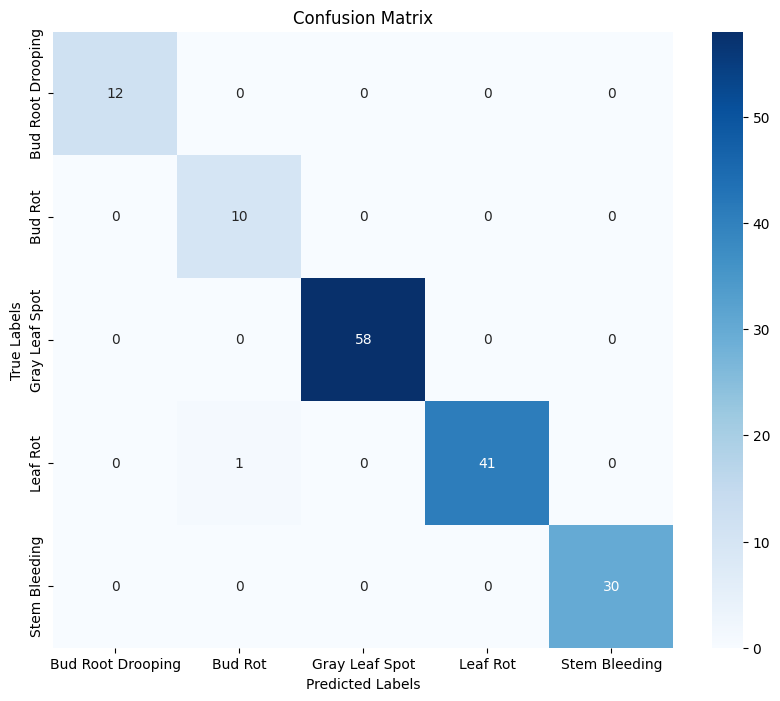

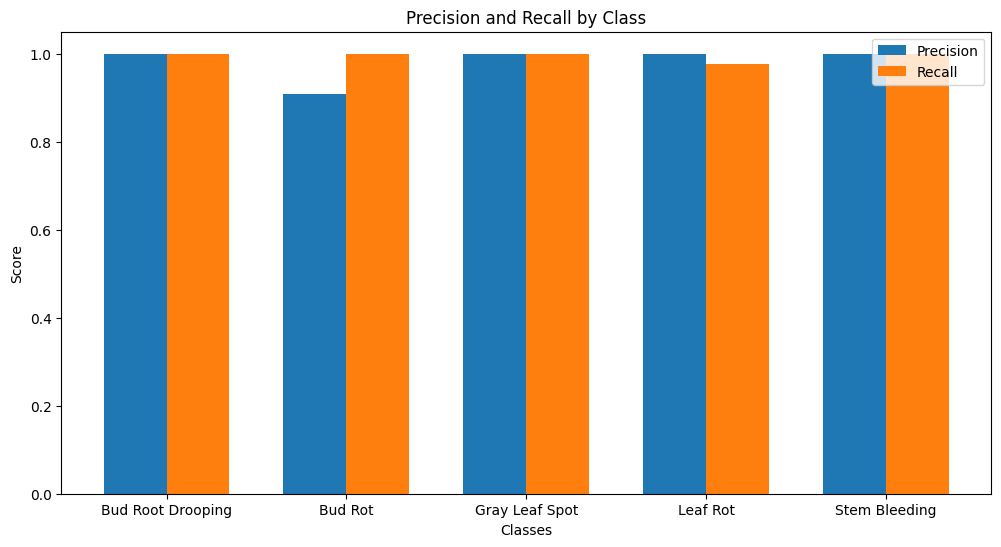

Epoch 5/5, Training Loss: 0.1362, Validation Accuracy: 0.9934
Class-wise Metrics:
Class: Bud Root Drooping, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Class: Bud Rot, Precision: 0.9091, Recall: 1.0000, F1 Score: 0.9524
Class: Gray Leaf Spot, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Class: Leaf Rot, Precision: 1.0000, Recall: 0.9762, F1 Score: 0.9880
Class: Stem Bleeding, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


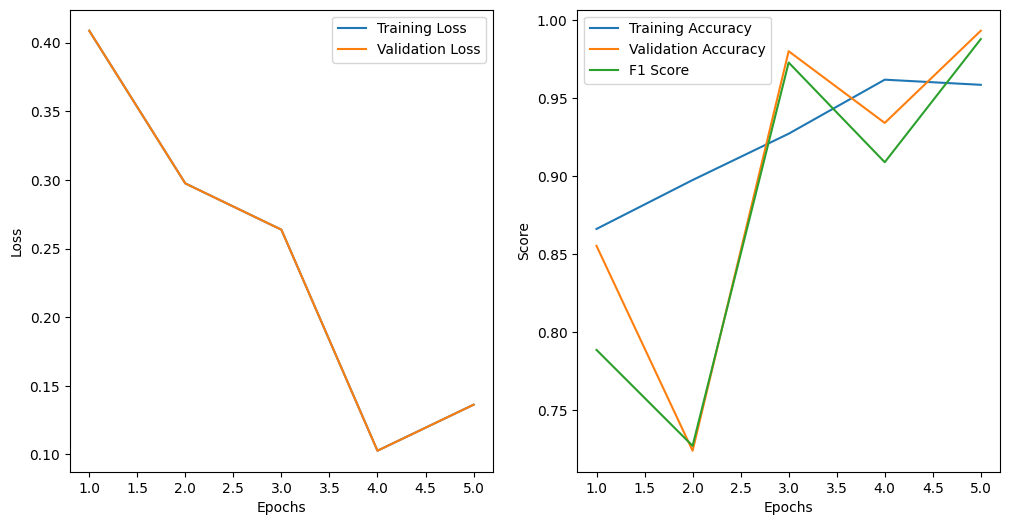

In [42]:
train(mobilenet_v2, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=num_epochs)

In [48]:
class CustomEffNetV2Model(nn.Module):
    def __init__(self, num_classes):
        super(CustomEffNetV2Model, self).__init__()
        self.effnet = timm.create_model('tf_efficientnetv2_b2', pretrained=True, num_classes=0, global_pool='avg')

        # Modifies the classifier
        self.classifier = nn.Linear(self.effnet.num_features, num_classes)

    def forward(self, x):
        x = self.effnet(x)
        x = self.classifier(x)
        return x



Train Epoch 1/5, Batch 1/38, Loss: 1.6692
Train Epoch 1/5, Batch 11/38, Loss: 1.6175
Train Epoch 1/5, Batch 21/38, Loss: 1.6275
Train Epoch 1/5, Batch 31/38, Loss: 1.6334


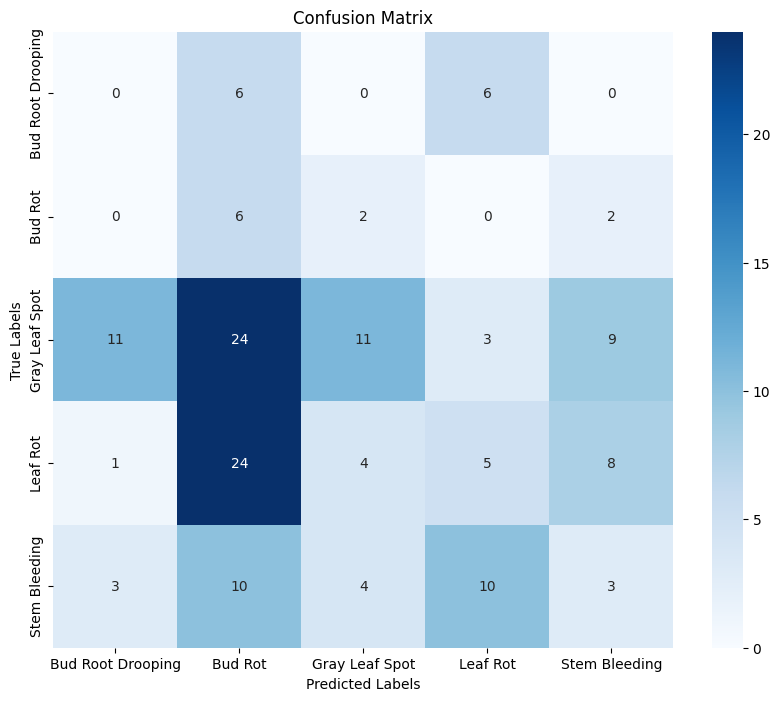

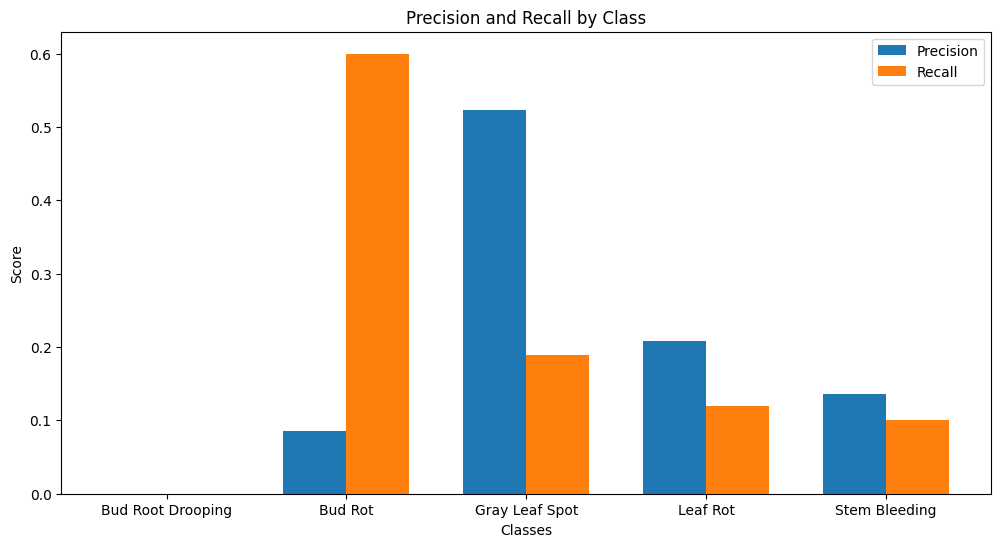

Epoch 1/5, Training Loss: 1.6466, Validation Accuracy: 0.1645
Class-wise Metrics:
Class: Bud Root Drooping, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Bud Rot, Precision: 0.0857, Recall: 0.6000, F1 Score: 0.1500
Class: Gray Leaf Spot, Precision: 0.5238, Recall: 0.1897, F1 Score: 0.2785
Class: Leaf Rot, Precision: 0.2083, Recall: 0.1190, F1 Score: 0.1515
Class: Stem Bleeding, Precision: 0.1364, Recall: 0.1000, F1 Score: 0.1154
Train Epoch 2/5, Batch 1/38, Loss: 1.6409
Train Epoch 2/5, Batch 11/38, Loss: 1.6410
Train Epoch 2/5, Batch 21/38, Loss: 1.6830
Train Epoch 2/5, Batch 31/38, Loss: 1.6887


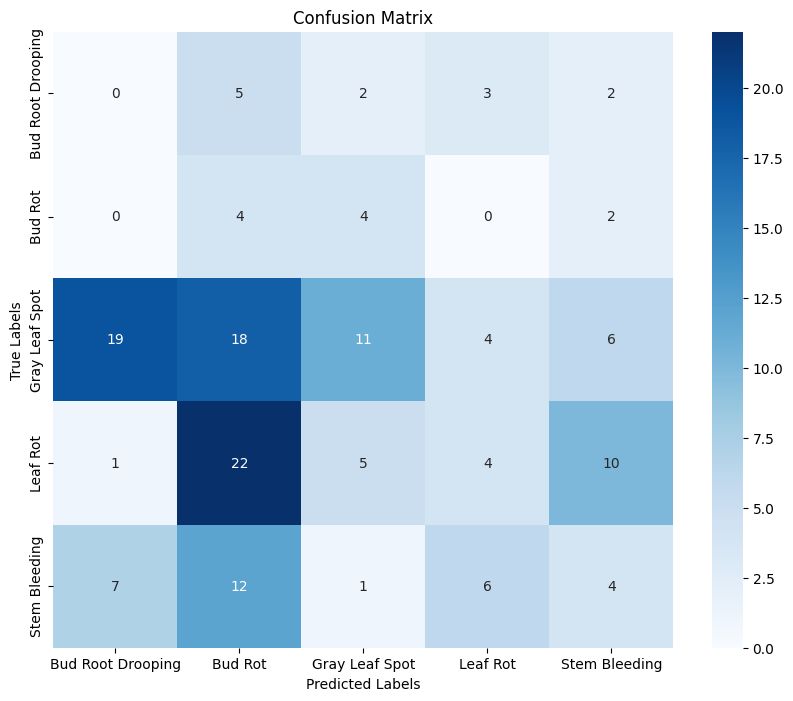

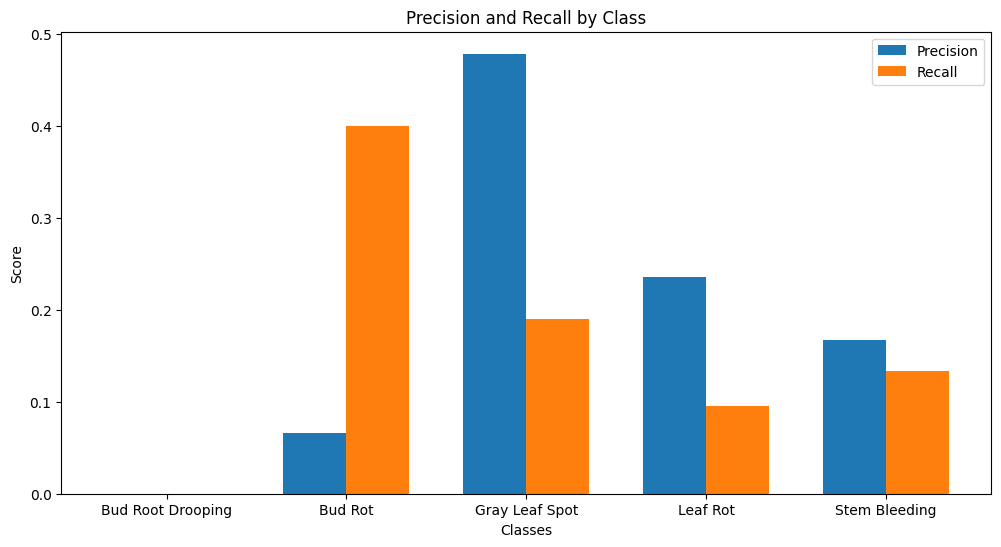

Epoch 2/5, Training Loss: 1.6466, Validation Accuracy: 0.1513
Class-wise Metrics:
Class: Bud Root Drooping, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Bud Rot, Precision: 0.0656, Recall: 0.4000, F1 Score: 0.1127
Class: Gray Leaf Spot, Precision: 0.4783, Recall: 0.1897, F1 Score: 0.2716
Class: Leaf Rot, Precision: 0.2353, Recall: 0.0952, F1 Score: 0.1356
Class: Stem Bleeding, Precision: 0.1667, Recall: 0.1333, F1 Score: 0.1481
Train Epoch 3/5, Batch 1/38, Loss: 1.6557
Train Epoch 3/5, Batch 11/38, Loss: 1.6187
Train Epoch 3/5, Batch 21/38, Loss: 1.6813
Train Epoch 3/5, Batch 31/38, Loss: 1.6138


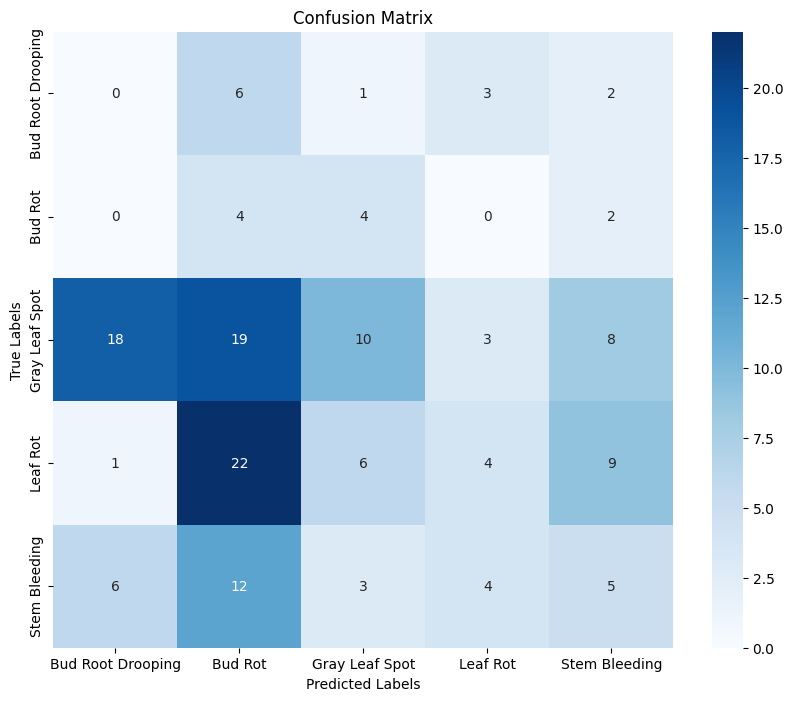

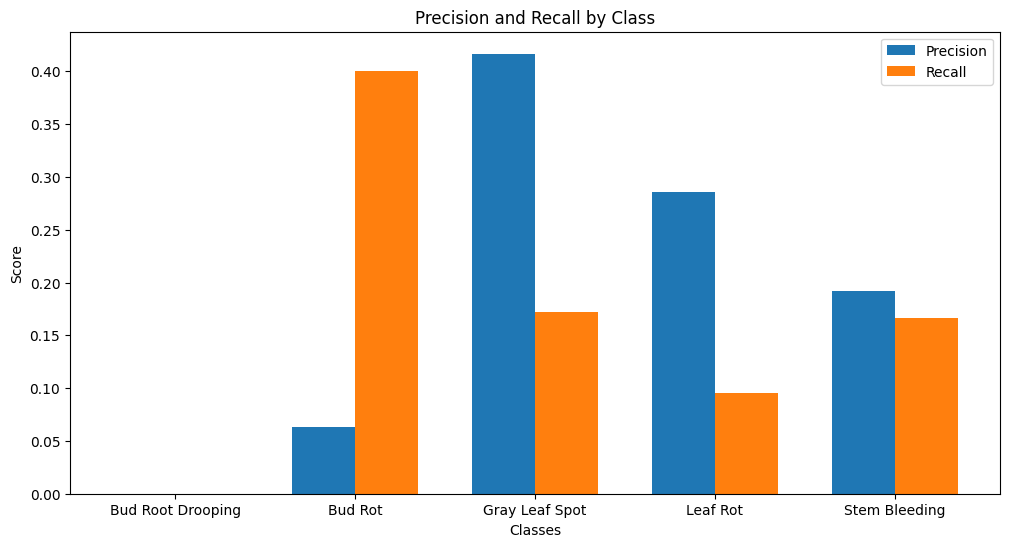

Epoch 3/5, Training Loss: 1.6408, Validation Accuracy: 0.1513
Class-wise Metrics:
Class: Bud Root Drooping, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Bud Rot, Precision: 0.0635, Recall: 0.4000, F1 Score: 0.1096
Class: Gray Leaf Spot, Precision: 0.4167, Recall: 0.1724, F1 Score: 0.2439
Class: Leaf Rot, Precision: 0.2857, Recall: 0.0952, F1 Score: 0.1429
Class: Stem Bleeding, Precision: 0.1923, Recall: 0.1667, F1 Score: 0.1786
Train Epoch 4/5, Batch 1/38, Loss: 1.6492
Train Epoch 4/5, Batch 11/38, Loss: 1.6351
Train Epoch 4/5, Batch 21/38, Loss: 1.6369
Train Epoch 4/5, Batch 31/38, Loss: 1.6643


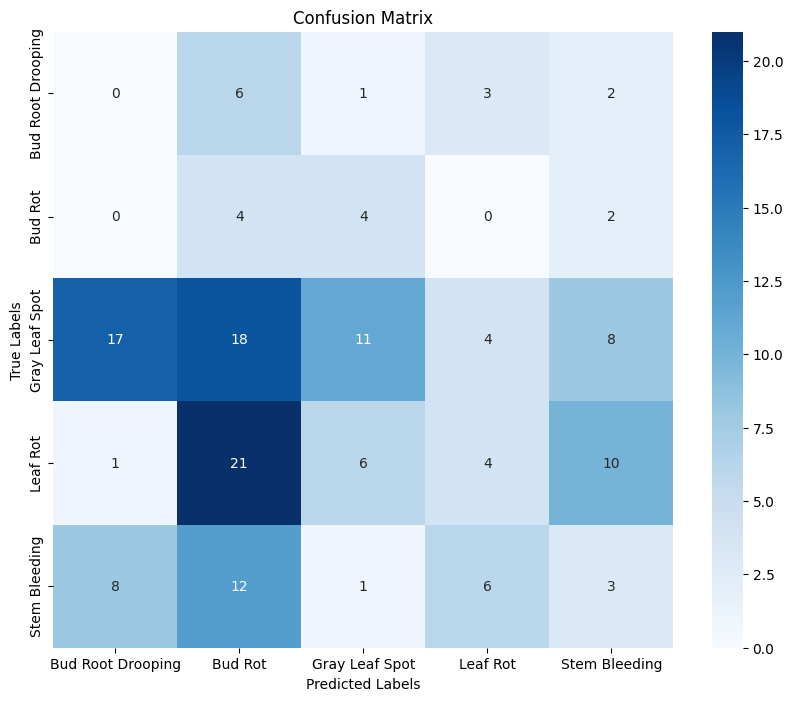

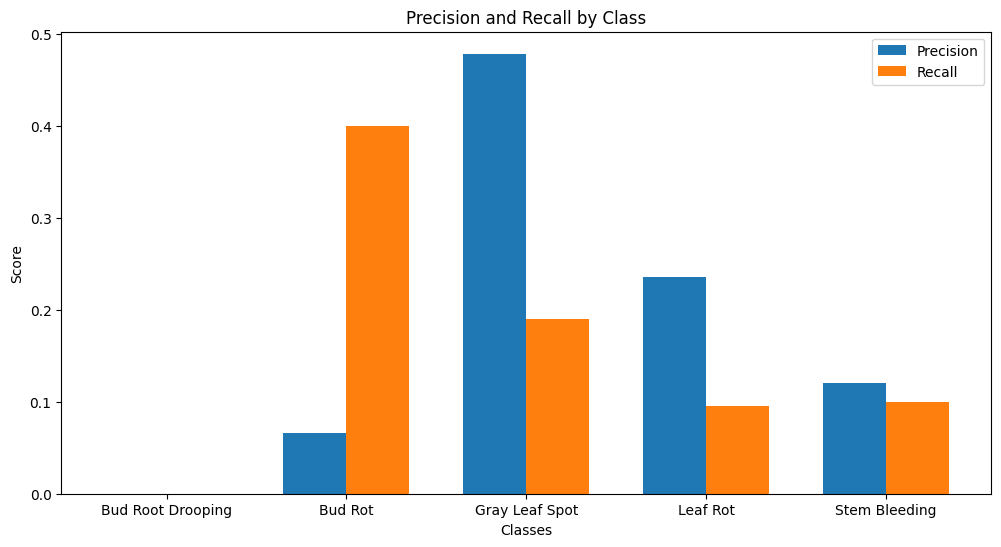

Epoch 4/5, Training Loss: 1.6448, Validation Accuracy: 0.1447
Class-wise Metrics:
Class: Bud Root Drooping, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Bud Rot, Precision: 0.0656, Recall: 0.4000, F1 Score: 0.1127
Class: Gray Leaf Spot, Precision: 0.4783, Recall: 0.1897, F1 Score: 0.2716
Class: Leaf Rot, Precision: 0.2353, Recall: 0.0952, F1 Score: 0.1356
Class: Stem Bleeding, Precision: 0.1200, Recall: 0.1000, F1 Score: 0.1091
Train Epoch 5/5, Batch 1/38, Loss: 1.6311
Train Epoch 5/5, Batch 11/38, Loss: 1.6056
Train Epoch 5/5, Batch 21/38, Loss: 1.6049
Train Epoch 5/5, Batch 31/38, Loss: 1.7104


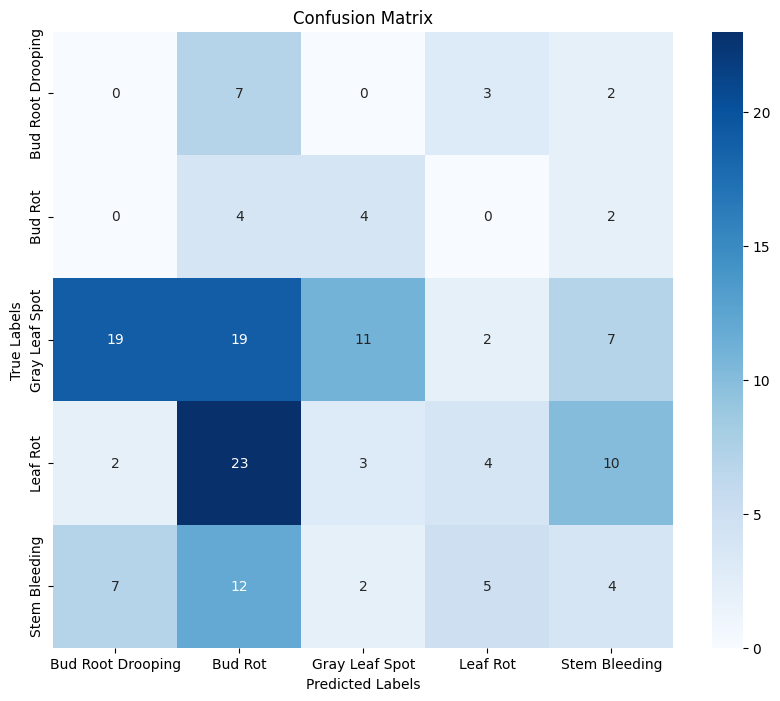

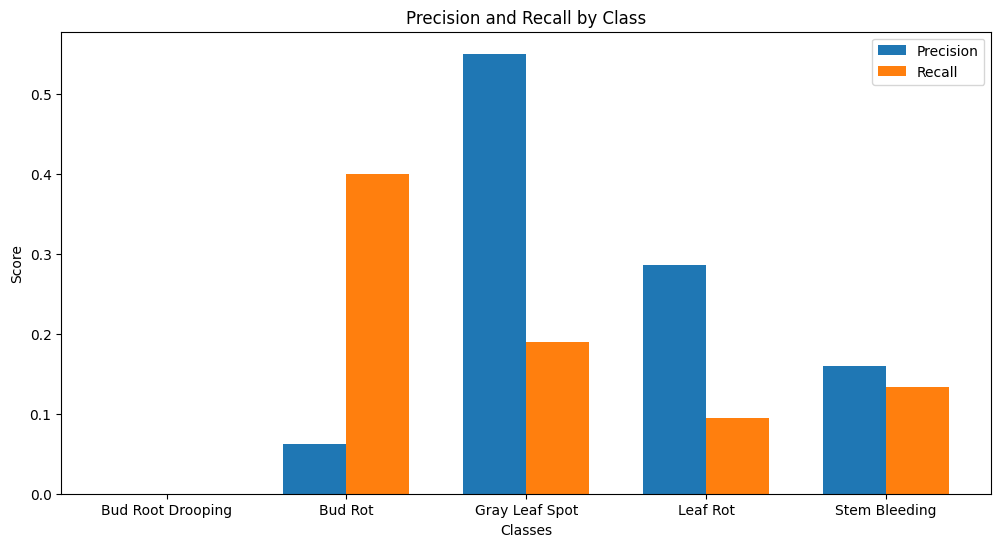

Epoch 5/5, Training Loss: 1.6462, Validation Accuracy: 0.1513
Class-wise Metrics:
Class: Bud Root Drooping, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Bud Rot, Precision: 0.0615, Recall: 0.4000, F1 Score: 0.1067
Class: Gray Leaf Spot, Precision: 0.5500, Recall: 0.1897, F1 Score: 0.2821
Class: Leaf Rot, Precision: 0.2857, Recall: 0.0952, F1 Score: 0.1429
Class: Stem Bleeding, Precision: 0.1600, Recall: 0.1333, F1 Score: 0.1455


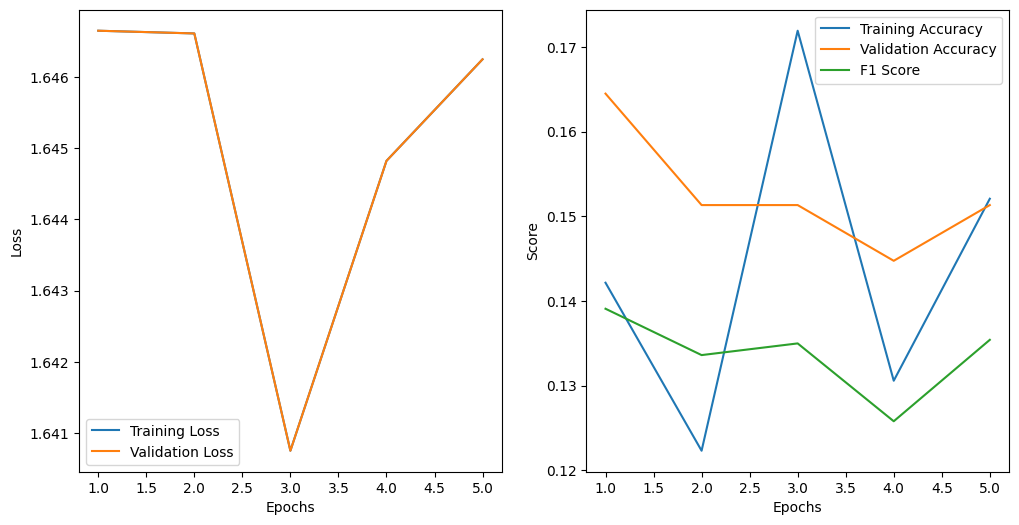

In [50]:
effnet_model = CustomEffNetV2Model(num_classes=5)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train(effnet_model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=5)

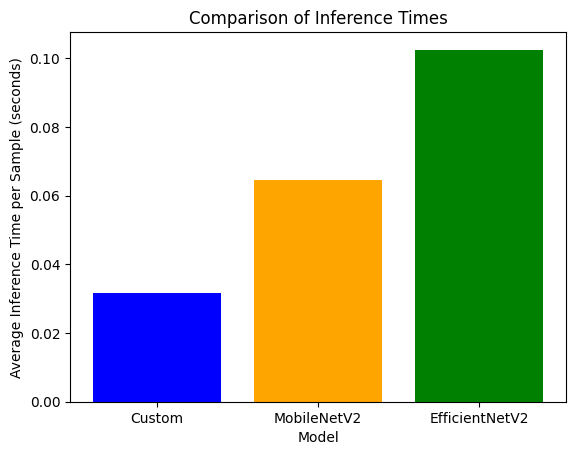

In [53]:
# Comparison of inference times of models
model.eval()
mobilenet_v2.eval()
effnet_model.eval()

model_names = ['Custom', 'MobileNetV2', 'EfficientNetV2']
avg_times = []
for model in [model, mobilenet_v2, effnet_model]:
    total_time = 0.0
    num_samples = 0

    # Iterates through the validation dataset with no gradient changes
    with torch.no_grad():
        for inputs, _ in val_dataloader:
            # inputs = inputs.to(device)
            # Measures inference time
            start_time = time.time()
            outputs = model(inputs)
            end_time = time.time()

            total_time += end_time - start_time
            num_samples += len(inputs)

    # Calculates average inference time per sample
    avg_time_per_sample = total_time / num_samples
    avg_times.append(avg_time_per_sample)

# Plots the bar chart
plt.bar(model_names, avg_times, color=['blue', 'orange', 'green'])
plt.xlabel('Model')
plt.ylabel('Average Inference Time per Sample (seconds)')
plt.title('Comparison of Inference Times')
plt.show()